In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def get_snap_pops(pop, n_snaps):
    # get pops of living individuals at timepoints
    snap_pops = [pop[pop.birth_date == 0]]
    timepoints = np.linspace(0, max(pop.birth_date.max(), pop.death_date.max()), n_snaps) # 0 to last event
    #print timepoints
    for i in range(1, n_snaps):
        snap_pops.append(pop[np.logical_and(pop.birth_date <= timepoints[i], np.logical_or(pop.death_date > timepoints[i], np.isnan(pop.death_date)))])
    return snap_pops

In [3]:
# auxiliary functions

def my_unique(agerange, ages):
    # adds the equivalent of minlength option of np.bincount to np.unique
    values, counts = np.unique(ages,return_counts=True)
    missing = np.setdiff1d(agerange, values)
    values = np.concatenate((values, missing))
    counts = np.concatenate((counts, np.zeros(len(missing)).astype(int)))
    sort_ix = np.argsort(values)
    return counts[sort_ix]

def my_argmax(arr, axis):
    if axis == 1:
        where = np.sum(arr, axis=1) == 0
        res = np.clip(np.argmax(arr, axis=1)-1, a_min=0, a_max=n_ages-1)
        res[where] = n_ages-1
        return res
    elif axis == 0:
        if np.sum(arr) == 0: return n_ages-1
        else: return max(0, np.argmax(arr, axis=0)-1)
    
def age_bins(agerange, pop, time):
    ages = time - pop[pop.age==0].birth_date.__array__()
    #print ages
    popsize = pop.id.size / n_ages
    age_bins = agerange[my_argmax(np.tile(agerange,popsize).reshape(popsize,len(agerange)) >= np.repeat(ages,len(agerange)).reshape(popsize,len(agerange)), axis=1)]
    return age_bins

In [4]:
def trait_timeline_single(pop, n_timepoints=30):
    timepoints = np.linspace(0, max(pop.birth_date.max(), pop.death_date.max()), n_timepoints)
    agerange = np.linspace(0, max_age, n_ages)
    snap_pops = get_snap_pops(pop, n_timepoints)
    
    # fill in for starting population
    death = snap_pops[0].groupby('age').mean().death
    reproduction = snap_pops[0].groupby('age').mean().reproduction
    death_var = snap_pops[0][snap_pops[0].age == n_ages-1].var().death
    reproduction_var = snap_pops[0][snap_pops[0].age == n_ages-1].var().reproduction
    popsize = [snap_pops[0].id.size / n_ages]
    variance = [1]
    agedist = np.zeros(n_ages)
    agedist[0] = 1.
    
    for i in range(1, n_timepoints):
        # traits
        death = np.hstack((death, snap_pops[i].groupby('age').mean().death))
        reproduction = np.hstack((reproduction, snap_pops[i].groupby('age').mean().reproduction))
        # traits variance
        death_var = np.hstack((death_var, snap_pops[i][snap_pops[i].age == n_ages-1].var().death))
        reproduction_var = np.hstack((reproduction_var, snap_pops[i][snap_pops[i].age == n_ages-1].var().reproduction))
        # popsize and variance
        popsize.append(snap_pops[i].id.size / n_ages)
        # variance
        u,c = np.unique(snap_pops[i][snap_pops[i].age == 0].id, return_counts=True)
        sort_ix = np.argsort(c)[::-1]
        variance.append(c[sort_ix][0] / float(popsize[-1])) # proportion of most frequent ID
        
        # age distribution
        agedist = np.vstack((agedist, my_unique(agerange, age_bins(agerange, snap_pops[i], timepoints[i])) / float(popsize[-1])))
        
    dft = pd.DataFrame()
    dft['age'] = np.tile(np.tile(pop.age.unique(), n_timepoints), 2)
    dft['timepoint'] = np.tile(np.repeat(timepoints, n_ages), 2)
    dft['trait'] = np.concatenate((death, reproduction))
    #print n_ages
    #print n_timepoints
    dft['type'] = np.repeat(['death', 'reproduction'], n_ages * n_timepoints)
    
    dftv = pd.DataFrame()
    #print timepoints
    #print death_var
    #print reproduction_var
    dftv['timepoint'] = timepoints
    dftv['death'] = death_var
    dftv['reproduction'] = reproduction_var
    
    dfps = pd.DataFrame()
    dfps['timepoint'] = timepoints
    dfps['popsize'] = np.array(popsize)
    dfps['variance'] = np.array(variance)
    
    dfad = pd.DataFrame()
    dfad['age'] = np.tile(agerange, n_timepoints)
    dfad['timepoint'] = np.repeat(timepoints, n_ages)
    dfad['agedist'] = agedist.flatten()
    
    return dft, dftv, dfps, dfad

In [5]:
def trait_timeline_all(pops, pop_labels, n_timepoints=10):
    dftf, dftvf, dfpsf, dfadf = trait_timeline_single(pops[0],n_timepoints)
    dftf['label'] = np.repeat(pop_labels[0], len(dftf.index))
    dftvf['label'] = np.repeat(pop_labels[0], len(dftvf.index))
    dfpsf['label'] = np.repeat(pop_labels[0], len(dfpsf.index))
    dfadf['label'] = np.repeat(pop_labels[0], len(dfadf.index))
    for i in range(1,len(pops)):
        dft, dftv, dfps, dfad = trait_timeline_single(pops[i],n_timepoints)
        dft['label'] = np.repeat(pop_labels[i], len(dft.index))
        dftv['label'] = np.repeat(pop_labels[i], len(dftv.index))
        dfps['label'] = np.repeat(pop_labels[i], len(dfps.index))
        dfad['label'] = np.repeat(pop_labels[i], len(dfad.index))
        dftf = dftf.append(dft)
        dftvf = dftvf.append(dftv)
        dfpsf = dfpsf.append(dfps)
        dfadf = dfadf.append(dfad)
        
    return dftf, dftvf, dfpsf, dfadf

# start data analysis

In [14]:
n_timepoints = 10

## get pops from first series run

In [15]:
dirpath = './series2/mage_5'
max_age = 5.
n_ages = 12
bio_ages = np.linspace(0,max_age,n_ages)

In [16]:
from os import listdir
from os.path import isfile, join
paths = [join(dirpath, f) for f in listdir(dirpath) if isfile(join(dirpath, f))]
paths.sort()
print paths

['./series2/mage_5/mut-single-mstd_0.25-mage_5.csv', './series2/mage_5/mut-single-mstd_0.50-mage_5.csv', './series2/mage_5/mut-single-mstd_1.00-mage_5.csv', './series2/mage_5/mut-whole-mstd_0.25-mage_5.csv', './series2/mage_5/mut-whole-mstd_0.50-mage_5.csv', './series2/mage_5/mut-whole-mstd_1.00-mage_5.csv']


In [17]:
pops1 = []
pop_labels1 = []
for path in paths:
    pop = pd.read_csv(path)
    pop.parent_id[pop.parent_id < 0] = np.nan
    pops1.append(pop)
    pop_labels1.append(path.split('/')[-1][:-4])

/home/asajina/pyenvs/jupyter/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


### construct dataframes

In [18]:
dft1, dftv1, dfps1, dfad1 = trait_timeline_all(pops1, pop_labels1, n_timepoints=n_timepoints)

## get pops from second series run

In [19]:
dirpath = './series2/mage_2'
max_age = 2.
n_ages = 12
bio_ages = np.linspace(0,max_age,n_ages)

In [20]:
from os import listdir
from os.path import isfile, join
paths = [join(dirpath, f) for f in listdir(dirpath) if isfile(join(dirpath, f))]
paths.sort()
print paths

['./series2/mage_2/mut-single-mstd_0.25-mage_2.csv', './series2/mage_2/mut-single-mstd_0.50-mage_2.csv', './series2/mage_2/mut-single-mstd_1.00-mage_2.csv', './series2/mage_2/mut-whole-mstd_0.25-mage_2.csv', './series2/mage_2/mut-whole-mstd_0.50-mage_2.csv', './series2/mage_2/mut-whole-mstd_1.00-mage_2.csv']


In [21]:
pops2 = []
pop_labels2 = []
for path in paths:
    pop = pd.read_csv(path)
    pop.parent_id[pop.parent_id < 0] = np.nan
    pops2.append(pop)
    pop_labels2.append(path.split('/')[-1][:-4])

/home/asajina/pyenvs/jupyter/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


### construct dataframes

In [22]:
dft2, dftv2, dfps2, dfad2 = trait_timeline_all(pops2, pop_labels2, n_timepoints=10)

## join dataframes

In [23]:
dft = dft1.append(dft2)
dftv = dftv1.append(dftv2)
pop_labels = dft.label.unique()
dfps = dfps1.append(dfps2)
dfad = dfad1.append(dfad2)
print pop_labels

['mut-single-mstd_0.25-mage_5' 'mut-single-mstd_0.50-mage_5'
 'mut-single-mstd_1.00-mage_5' 'mut-whole-mstd_0.25-mage_5'
 'mut-whole-mstd_0.50-mage_5' 'mut-whole-mstd_1.00-mage_5'
 'mut-single-mstd_0.25-mage_2' 'mut-single-mstd_0.50-mage_2'
 'mut-single-mstd_1.00-mage_2' 'mut-whole-mstd_0.25-mage_2'
 'mut-whole-mstd_0.50-mage_2' 'mut-whole-mstd_1.00-mage_2']


# Trait evolution figure

In [24]:
def get_numbers(s):
    newstr = ''.join((ch if ch in '0123456789.' else ' ') for ch in s)
    listOfNumbers = [float(i) for i in newstr.split()]
    return listOfNumbers

def process_label(label):
    which = 'single' if 'single' in label else 'whole'
    mstd, mage = get_numbers(label)
    return '{0} | {1} = {2} | {3} = {4}'.format(which,r'$\theta$',mstd,r'$L$',mage)

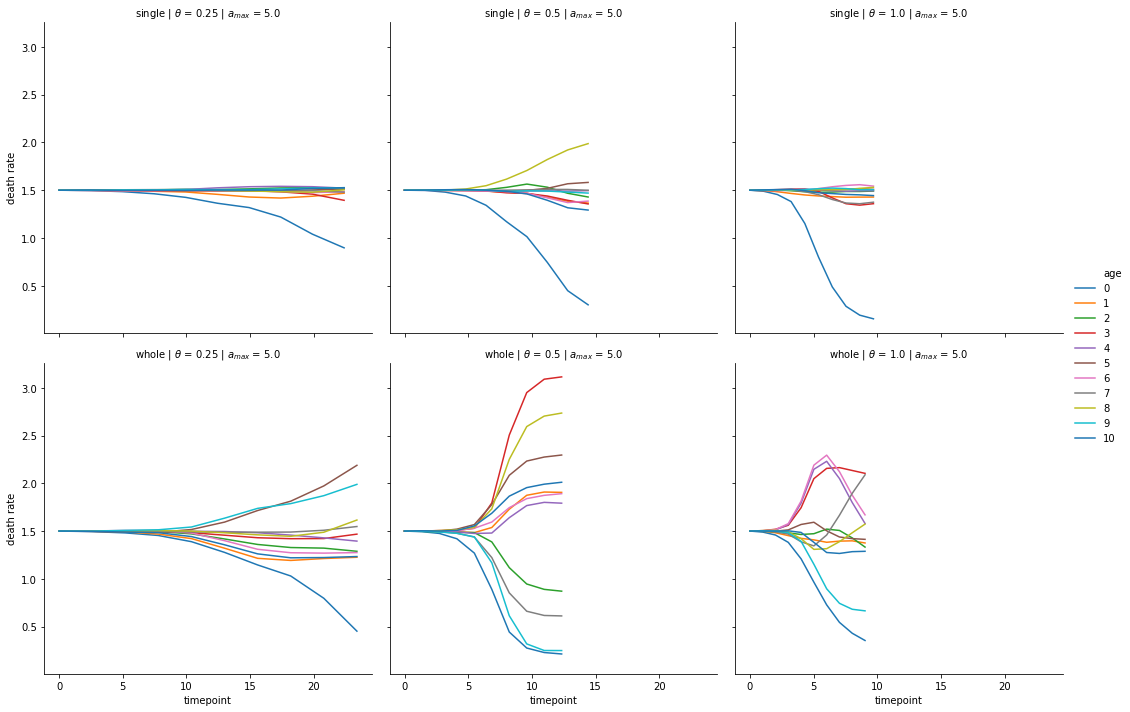

In [52]:
pal = sns.color_palette(n_colors=n_ages-1)
dft1['parameters'] = dft1['label'].apply(process_label)

g = sns.relplot(data=dft1[np.logical_and(dft1.age<n_ages-1, dft1.type=='death')], x='timepoint', y='trait', hue='age', kind='line', col='parameters', col_wrap=3,palette=pal)
g.set_titles('{col_name}')
g.axes[0].set_ylabel('death rate')
g.axes[3].set_ylabel('death rate')
#g.axes[1][0].set_ylabel('birth rate')

init_death = 1.5
init_repr = 2.

# shaded area for death rate variance
#for ax, label in zip(g.axes.flatten()[:len(pop_labels)], pop_labels1):
#    x = dftv[dftv.label == label].timepoint
#    y = dftv[dftv.label == label].death
#    ax.fill_between(x, init_death-y, init_death+y, color='gray', alpha=0.2)
# shaded area for birth rate variance
#for ax, label in zip(g.axes.flatten()[len(pop_labels1):], pop_labels1):
#    x = dftv[dftv.label == label].timepoint
#    y = dftv[dftv.label == label].reproduction
#    ax.fill_between(x, init_repr-y, init_repr+y, color='gray', alpha=0.2)
    
g.savefig('/home/asajina/repos/thesis-paper/figures/trait_evo2', dpi=600)

______________

# Population size figure

In [26]:
def get_numbers(s):
    newstr = ''.join((ch if ch in '0123456789.' else ' ') for ch in s)
    listOfNumbers = [float(i) for i in newstr.split()]
    return listOfNumbers

def process_label(label):
    which = 'single' if 'single' in label else 'whole'
    mstd, mage = get_numbers(label)
    return '{0} = {1} | {2} = {3}'.format(r'$\theta$',mstd,r'$a_{max}$',mage)

In [27]:
dfps['mutation type'] = dfps.shape[0]
dfps['mutation type'][dfps.label.str.contains('single')] = 'single'
dfps['mutation type'][dfps.label.str.contains('whole')] = 'whole'
dfps['parameters'] = dfps['label'].apply(process_label)

/home/asajina/pyenvs/jupyter/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/asajina/pyenvs/jupyter/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


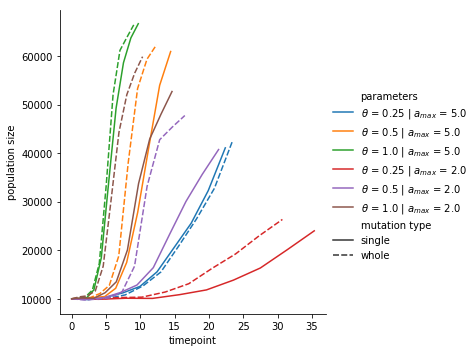

In [33]:
g = sns.relplot(data=dfps, x='timepoint', y='popsize', hue='parameters', style='mutation type', kind='line')
g.set_ylabels('population size')
g.savefig('/home/asajina/repos/thesis-paper/figures/population_size.png', dpi=600)

### a naive variance measure

In [ ]:
g = sns.relplot(data=dfps, x='timepoint', y='variance', hue='parameters', style='mutation type', kind='line')
g.set_ylabels('proportion of most frequent ID')

_______________

## Age distribution figure

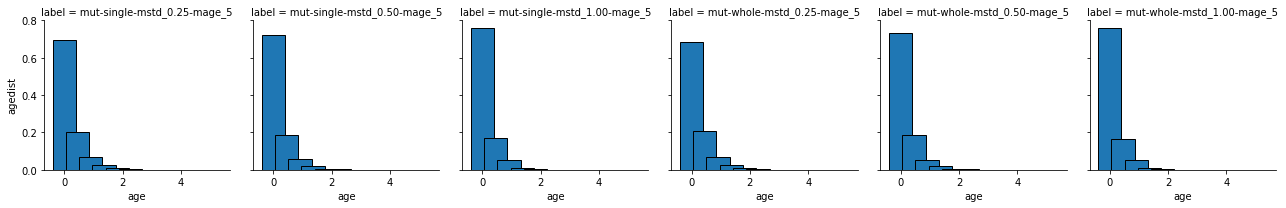

In [32]:
dfadf = pd.DataFrame()
dfadf['age'] = np.tile(dfad1.age.unique(),len(pop_labels1))
dfadf['agedist'] = np.hstack([dfad1[dfad1.label == label].groupby('age').agedist.mean().values for label in pop_labels1])
dfadf['label'] = np.repeat(pop_labels1, n_ages)

g = sns.FacetGrid(dfadf, col='label')
g.map(plt.bar, 'age', 'agedist', linewidth=1, edgecolor='black')

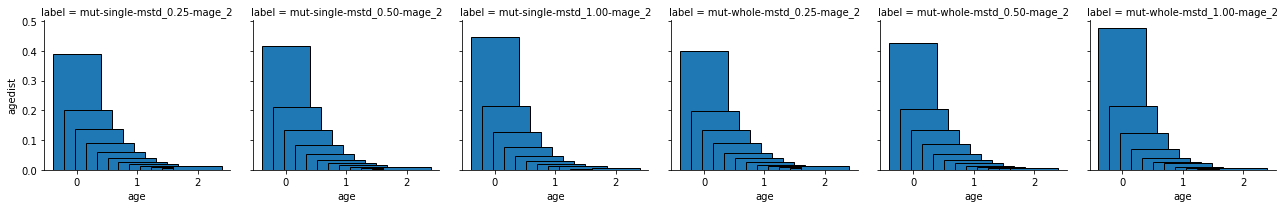

In [41]:
dfadf = pd.DataFrame()
dfadf['age'] = np.tile(dfad2.age.unique(),len(pop_labels2))
dfadf['agedist'] = np.hstack([dfad2[dfad2.label == label].groupby('age').agedist.mean().values for label in pop_labels2])
dfadf['label'] = np.repeat(pop_labels2, n_ages)

g = sns.FacetGrid(dfadf, col='label')
g.map(plt.bar, 'age', 'agedist', linewidth=1, edgecolor='black')

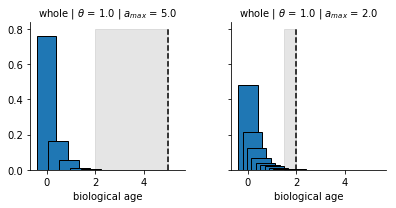

In [51]:
dfadf = pd.DataFrame()
dfadf['age'] = np.hstack((dfad1.age.unique(),dfad2.age.unique()))
dfadf['agedist'] = np.hstack(([dfad1[dfad1.label == pop_labels1[-1]].groupby('age').agedist.mean().values, dfad2[dfad2.label == pop_labels2[-1]].groupby('age').agedist.mean().values]))
dfadf['label'] = np.repeat([pop_labels1[-1],pop_labels2[-1]], n_ages)
dfadf['parameters'] = dfadf['label'].apply(process_label)

g = sns.FacetGrid(dfadf, col='parameters')
g.map(plt.bar, 'age', 'agedist', linewidth=1, edgecolor='black')
g.set_titles('{col_name}')
g.axes.flatten()[0].fill_between(np.arange(2,6),0,0.8,color='gray', alpha=0.2)
g.axes.flatten()[0].vlines(5,0,0.8,linestyle='--')
g.axes.flatten()[1].fill_between(np.linspace(1.5,2,10),0,0.8,color='gray', alpha=0.2)
g.axes.flatten()[1].vlines(2,0,0.8,linestyle='--')
g.set_ylabels('')
g.set_xlabels('biological age')

g.savefig('/home/asajina/repos/thesis-paper/figures/age_dist.png', dpi=600)

# Step-funtions figure

In [30]:
def get_numbers(s):
    newstr = ''.join((ch if ch in '0123456789.' else ' ') for ch in s)
    listOfNumbers = [float(i) for i in newstr.split()]
    return listOfNumbers

def process_label(label):
    which = 'single' if 'single' in label else 'whole'
    mstd, mage = get_numbers(label)
    return '{0} | {1} = {2} | {3} = {4}'.format(which,r'$\theta$',mstd,r'$a_{max}$',mage)

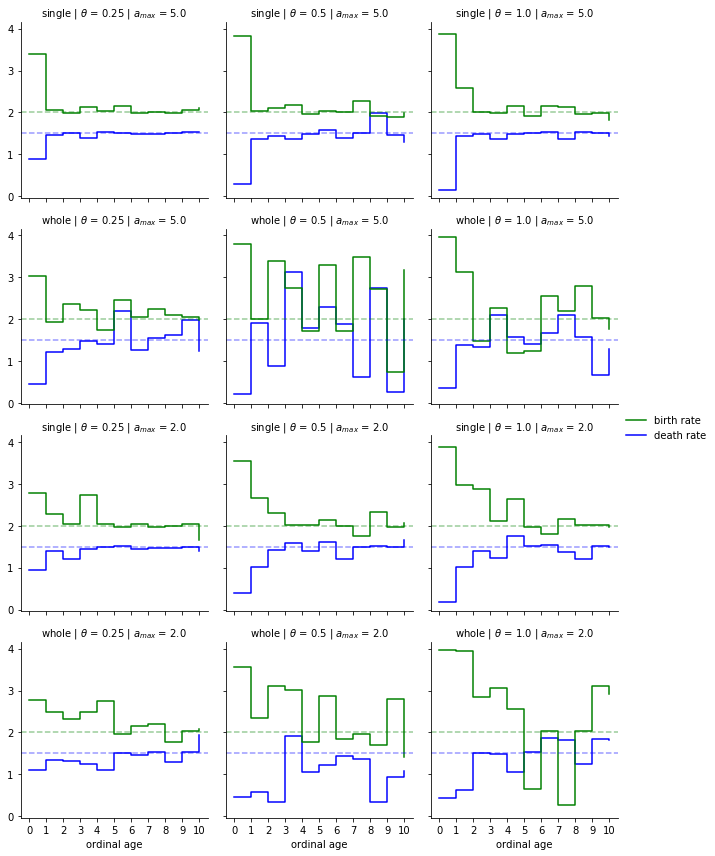

In [35]:
dft_alive = dft[dft.timepoint.isin([dft[dft.label==label].timepoint.max() for label in pop_labels])]
dft_alive = dft_alive[dft_alive.age<n_ages-1]
dft_alive.drop(columns=['timepoint'], inplace=True)

df = pd.DataFrame()
df['death'] = dft_alive[dft_alive.type=='death'].trait.values
df['birth'] = dft_alive[dft_alive.type=='reproduction'].trait.values
df['age'] = dft_alive[dft_alive.type=='reproduction'].age.values
df['label'] = dft_alive[dft_alive.type=='reproduction'].label.values
df['label'] = df['label'].apply(process_label)

g = sns.FacetGrid(df, col='label', col_wrap=3)
g.map(plt.step, 'age', 'death', where='post', label='death rate', color='blue')#, linestyle='-')
g.map(plt.step, 'age', 'birth', where='post', label='birth rate', color='green')#, linestyle='--')
for ax in g.axes:
    ax.axhline(y=1.5, color='blue', linestyle='--', alpha=0.4)
    ax.axhline(y=2, color='green', linestyle='--', alpha=0.4)
g.set_titles('{col_name}')
g.set_ylabels('')
g.set_xlabels('ordinal age')
#g.set_xticklabels(np.arange(11),1)
g.add_legend()
for ax in g.axes.flatten():
    ax.set_xticks(np.arange(n_ages-1).astype(int))
g.savefig('/home/asajina/repos/thesis-paper/figures/step-mage_5_2.png', dpi=600)

_______________

# trying stuff out

In [42]:
def most_frequent_ID(pop,n=20):
    p = pop[pop.alive == 1]
    u,c = np.unique(p.id, return_counts=True)
    sort_ix = np.argsort(c)[::-1] # ascending
    return (c[sort_ix]/float(np.sum(c)))[:n], u[sort_ix][:n]

In [45]:
freq = []
ids = []
for pop in pops2:
    c,u = most_frequent_ID(pop)
    freq = np.hstack((freq, c))
    ids = np.hstack((ids, u))
    
dfid = pd.DataFrame()
dfid['freq'] = freq
dfid['id'] = ids.astype(int).astype(str)
dfid['label'] = np.repeat(pop_labels2,20)

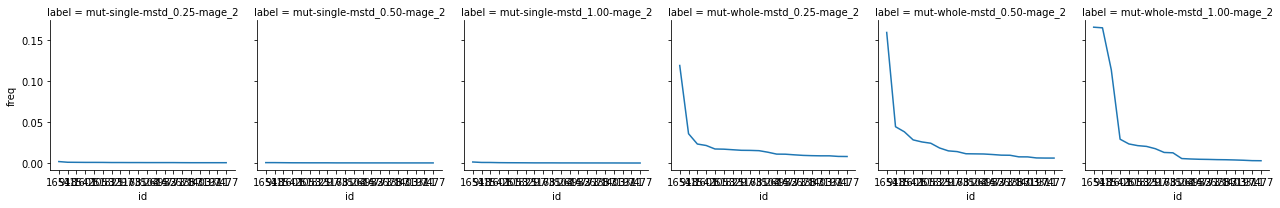

In [46]:
g = sns.FacetGrid(dfid, col='label')
g.map(plt.plot, 'id', 'freq')

In [ ]:
p = pop[pop.alive == 1]
u,c = np.unique(p.id, return_counts=True)
sort_ix = np.argsort(c)[::-1] # ascending

how_many = 20

xlabel = u[sort_ix]
y = (c[sort_ix]/float(np.sum(c)))[:how_many]
plt.plot(y)
plt.xticks(np.arange(how_many), xlabel[:how_many], rotation=45)
plt.xlabel('ID')
plt.ylabel('frequency')
plt.show()

In [ ]:
#dft2 = np.copy(dft)
for label in pop_labels:
    print label
    print dft[np.logical_and(dft.label==label, dft[dft.label==label].timepoint.max())].groupby('age').var()

In [ ]:
for pop, label in zip(pops,pop_labels):
    print label
    print np.mean(pop.death_date - pop.birth_date)